## Разработка DQN-агента
В рамках данного ноутбука показана разработка DQN-агента, а также пример его использования на случайных данных

In [ ]:
import pandas as pd
from ..utils import envGenerator
file_name = 'vacancies_df.xlsx'
generator_object = envGenerator(file_name,5000)
observations = generator_object.environment

##### Нейронная сеть, лежащая в основе DQN

$2\times 1 \underset{(reLU)}→ 128\times 1 \underset{(reLU)}→ 64\times 1 \underset{(reLU)}→ N\times 1$ ($N$ - количество возможных действий)

In [2]:
import torch.nn as nn

class DQNSolver(nn.Module):
    def __init__(self, n_actions, obvs_size):
        super().__init__()
        self.agent_net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.agent_net(x)

##### DQN-агент, в рамках которого принимаются решения, происходит переобучение и сохраняются веса

In [3]:
import pickle
import random
import torch

class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 exploration_max, exploration_min, exploration_decay, pretrained,
                 memory):

        # параметры-константы
        self.state_space = state_space
        self.action_space = action_space
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # DQN-сеть  
        self.dqn = DQNSolver(action_space, state_space).to(self.device)

        # загрузка предобученных весов DQN-сети
        if self.pretrained:
            self.dqn.load_state_dict(torch.load("DQN.pt", map_location=torch.device(self.device)))

        # adam-оптимизатор переобучения весов
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # загрузка offline-данных о среде
        self.STATE_MEM, self.ACTION_MEM, self.REWARD_MEM, self.STATE2_MEM = memory
  
        # размер батчей
        self.memory_sample_size = batch_size
        
        # параметры для обучения
        self.gamma = gamma # важность наград в будущем
        self.l1 = nn.SmoothL1Loss().to(self.device) # функция потерь Хьюбера
        self.exploration_max = exploration_max # максимальный эпсилон
        self.exploration_rate = exploration_max # эпсилон
        self.exploration_min = exploration_min # минимальный эпсилон
        self.exploration_decay = exploration_decay # степень уменьшения эпсилона
    
    def batch_experiences(self):
        """
        Получение батчей из среды
        """
        idx = random.choices(range(self.STATE_MEM.shape[0]), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        return STATE, ACTION, REWARD, STATE2
    
    def act(self, state):
        """
        Epsilon-greedy принятие решений
        """
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        else:
            return torch.argmax(self.dqn(state.to(self.device)), dim=0)
    
    def experience_replay(self):
        """
        Процесс переобучения
        """
        STATE, ACTION, REWARD, STATE2 = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        losses = []

        # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
        for index, state in enumerate(STATE):
            self.optimizer.zero_grad()
            indexed_reward = torch.Tensor([REWARD[index]])
            indexed_state = torch.Tensor(state)
            indexed_state2 = torch.Tensor(STATE2[index])
            indexed_action = torch.Tensor([ACTION[index]])
            target = indexed_reward + self.gamma * self.dqn(indexed_state2).max(0).values.unsqueeze(0)
            current = self.dqn(indexed_state).gather(0,indexed_action.long())
            loss = self.l1(current, target)
            losses.append(loss.detach().numpy())
            loss.backward()
            self.optimizer.step()

        return losses

##### Обучение DQN-агента с последующим применением на основе сгенерированных данных

In [6]:
from tqdm import tqdm 
import json
import numpy as np

def run(training_mode, num_episodes=101, config_filename='config.json'):
    """
      Функция обучения DQN-агента

      :params:
      training_mode: bool
        - флаг, обозначающий необходимость записи весов обученной сети в "DQN.pt"
      num_episodes: int
        - число эпизодов обучения
      config_filename: str
        - название файла с конфигом для агента. Корректное оформление конфига
        ниже с пометкой __конфиг__

      :returns:
      agent: DQNAgent
        - обученный DQN-агент
      losses_for_plot: list
        - список значений функции потерь объема num_episodes x batch_size 
      av_losses_for_plot: list
        - список средних значений функции потерь объема num_episodes x batch_size / 100
    """
    observation_space = observations.shape[0]
    action_space = len(generator_object.actions2idx)
    
    mem_states = torch.Tensor(observations['state'].iloc[:-1].tolist())
    mem_next_states = torch.Tensor(observations['state'].iloc[1:].tolist())
    mem_rewards = torch.Tensor(observations['reward'].tolist())
    mem_actions = torch.Tensor(observations['action'].tolist())

    max_mem, gamma, max_eps, min_eps, eps_decay, lr, batch_size = None, None, None, None, None, None, None

    """
    __конфиг__
    
    {'max_eps': 1, 'min_eps': 0.02, 'eps_decay': 0.99, 
    'gamma': 0.95, 'mem_size': 5000, 'batch_size': 32, 
    'lr': 0.00025, 'skills': ['геймдев', 'акварель'],
    'model_name': 'q_vacancy_research'}
    """

    with open(config_filename, 'r', encoding='utf-8') as f:
      config_contents = json.load(f)
      max_mem = config_contents['mem_size']
      gamma = config_contents['gamma']
      max_eps = config_contents['max_eps']
      min_eps = config_contents['min_eps']
      eps_decay = config_contents['eps_decay']
      lr = config_contents['lr']
      batch_size = config_contents['batch_size']

    agent = DQNAgent(
      state_space=observation_space,
      action_space=action_space,
      max_memory_size=max_mem,
      batch_size=batch_size,
      gamma=gamma,
      lr=lr,
      exploration_max=max_eps,
      exploration_min=min_eps,
      exploration_decay=eps_decay,
      pretrained=(not training_mode),
      memory=(mem_states,mem_actions,mem_rewards,mem_next_states)
    )

    losses_for_verbose = []
    losses_for_plot = []
    av_losses_for_plot = []

    for ep_num in tqdm(range(num_episodes)):
        if training_mode:
            losses = agent.experience_replay()
            losses_for_verbose += losses
            losses_for_plot += losses
        if ep_num != 0 and ep_num % 100 == 0:
            print(f"Episode {ep_num}. Av. loss: {np.mean(losses_for_verbose)}")
            av_losses_for_plot.append(np.mean(losses_for_verbose))
            losses_for_verbose = []
    
    if training_mode:
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(losses_for_plot, f)

        torch.save(agent.dqn.state_dict(), "DQN.pt")  

    return agent, losses_for_plot, av_losses_for_plot

In [7]:
trained_model, losses, av_losses = run(True,num_episodes=1001)
losses = [loss.item() for loss in losses]

 10%|█         | 104/1001 [00:03<00:34, 25.92it/s]

Episode 100. Av. loss: 0.2384304702281952


 20%|██        | 203/1001 [00:07<00:31, 25.62it/s]

Episode 200. Av. loss: 0.1702439934015274


 30%|███       | 305/1001 [00:11<00:27, 25.22it/s]

Episode 300. Av. loss: 0.16809482872486115


 40%|████      | 404/1001 [00:15<00:23, 25.05it/s]

Episode 400. Av. loss: 0.16668660938739777


 51%|█████     | 506/1001 [00:19<00:18, 26.16it/s]

Episode 500. Av. loss: 0.16536100208759308


 60%|██████    | 605/1001 [00:23<00:15, 25.41it/s]

Episode 600. Av. loss: 0.16925553977489471


 70%|███████   | 704/1001 [00:27<00:11, 25.48it/s]

Episode 700. Av. loss: 0.16819792985916138


 81%|████████  | 806/1001 [00:31<00:07, 26.27it/s]

Episode 800. Av. loss: 0.1685434728860855


 90%|█████████ | 905/1001 [00:35<00:04, 22.58it/s]

Episode 900. Av. loss: 0.16755767166614532


100%|██████████| 1001/1001 [00:39<00:00, 25.30it/s]


Episode 1000. Av. loss: 0.17360496520996094


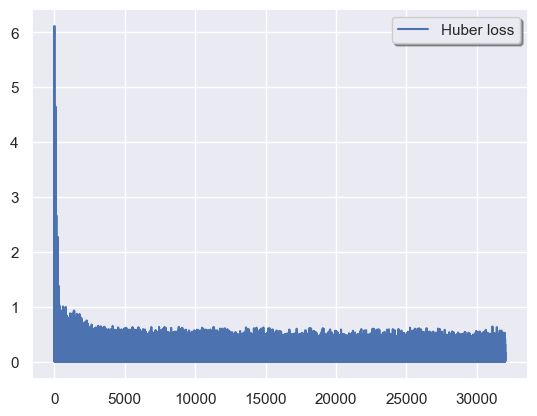

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.plot(losses, label='Huber loss')
plt.legend(loc='best', fancybox=True, shadow=True)

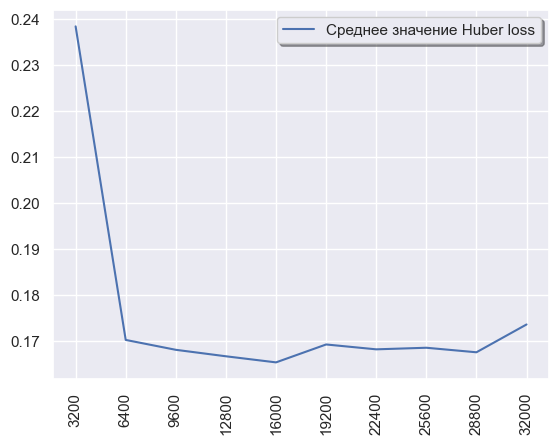

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.plot(av_losses, label='Среднее значение Huber loss')
plt.xticks(range(0,10), np.arange(1,11,1)*3200, rotation='vertical')
plt.legend(loc='best', fancybox=True, shadow=True)

In [14]:
generated_records = []
for _ in range(5):
  random_age = random.randint(14, 85)
  random_profficiency = random.randint(0,1)
  recommendation = trained_model.dqn(torch.Tensor([random_age,random_profficiency]))
  generated_records.append(
    {'возраст': random_age, 'навык': generator_object.names2idx[random_profficiency],
     'рекомендация': generator_object.actions2idx[recommendation.argmax(0).item()], 
     'Q-значение':torch.max(recommendation).item()}
  )
pd.DataFrame(generated_records)

,возраст,навык,рекомендация,Q-значение
0,48,акварель,юристы,0.058868
1,23,геймдев,юристы,0.058868
2,69,акварель,юристы,0.058868
3,14,геймдев,началокарьеры,0.063783
4,21,акварель,наука,0.077453
